# ボリュームクロップ問題分析: Axial方向の背景過多

## 問題
axial(横断面)方向のスライス画像に背景領域が多く含まれている。

## 調査内容
1. ボリュームクロップのパラメータ(`cut_li*.txt`)を確認
2. クロップされたボリュームのサイズと内容を検証
3. 3方向(axial, coronal, sagittal)での違いを比較
4. クロップ領域とアノテーション領域の対応を確認

## データフロー
```
元データ (data/train/)
  ├── inp1003.nii.gz (CT画像)
  ├── ans1003.nii (アノテーション)
  └── cut_li1003.txt (クロップ情報)
       ↓ [cut_train.py でクロップ]
処理済みデータ (data/processed_train/)
  └── inp1003/
      └── {vertebra_id}/
          ├── cut_inp1003.nii.gz (クロップされたCT)
          └── cut_ans1003.nii (クロップされたアノテーション)
       ↓ [slice_train.py でスライス化]
スライスデータ (data/slice_train/axial/)
  └── inp1003/
      └── {vertebra_id}/
          └── slice_XXX.nii
```

## 1. セットアップ

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
import matplotlib.font_manager as fm
noto_font_path = Path("/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
if noto_font_path.exists():
    fm.fontManager.addfont(str(noto_font_path))
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] + plt.rcParams['font.sans-serif']

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 100

# プロジェクトルート
PROJECT_ROOT = Path().resolve().parent.parent
DATA_ROOT = PROJECT_ROOT / "data"

print(f"✅ セットアップ完了")
print(f"プロジェクトルート: {PROJECT_ROOT}")

✅ セットアップ完了
プロジェクトルート: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka


## 2. クロップパラメータの解析

In [2]:
def parse_cut_file(cut_file_path: Path) -> pd.DataFrame:
    """
    cut_li*.txt ファイルを解析
    
    フォーマット:
    vertebra_num, slb, slb2, slice_count, base_size, x_start, x_end, y_start, y_end, z_start, z_end
    """
    data = []
    with open(cut_file_path) as f:
        for line in f:
            line = line.strip().rstrip(',')
            if not line:
                continue
            vals = list(map(int, line.split(',')))
            data.append({
                'vertebra_num': vals[0],
                'slb': vals[1],
                'slb2': vals[2],
                'slice_count': vals[3],
                'base_size': vals[4],
                'x_start': vals[5],
                'x_end': vals[6],
                'y_start': vals[7],
                'y_end': vals[8],
                'z_start': vals[9],
                'z_end': vals[10],
                'x_size': vals[6] - vals[5],
                'y_size': vals[8] - vals[7],
                'z_size': vals[10] - vals[9]
            })
    return pd.DataFrame(data)

# サンプルケースのクロップ情報を読み込み
cut_file = DATA_ROOT / "train/cut_li1003.txt"
cut_info_df = parse_cut_file(cut_file)

print("【クロップパラメータ】")
print(cut_info_df.to_string(index=False))

# 統計情報
print("\n【クロップサイズ統計】")
print(f"X方向サイズ: {cut_info_df['x_size'].min()} ~ {cut_info_df['x_size'].max()} (平均: {cut_info_df['x_size'].mean():.1f})")
print(f"Y方向サイズ: {cut_info_df['y_size'].min()} ~ {cut_info_df['y_size'].max()} (平均: {cut_info_df['y_size'].mean():.1f})")
print(f"Z方向サイズ: {cut_info_df['z_size'].min()} ~ {cut_info_df['z_size'].max()} (平均: {cut_info_df['z_size'].mean():.1f})")

【クロップパラメータ】
 vertebra_num  slb  slb2  slice_count  base_size  x_start  x_end  y_start  y_end  z_start  z_end  x_size  y_size  z_size
           27   15    21          211        299      164    333      150    302      557    671     169     152     114
           28   15    21          212        299      168    329      149    310      596    734     161     161     138
           29   15    21          211        299      172    339      145    302      644    797     167     157     153
           30   15    21          211        299      183    343      141    296      716    866     160     155     150
           31   15    21          211        299      189    339      141    293      785    923     150     152     138
           32   15    21          211        299      208    324      141    285      845    986     116     144     141
           33   15    21          211        299      208    328      139    283      902   1044     120     144     142
           34   15  

## 3. クロップサイズの可視化

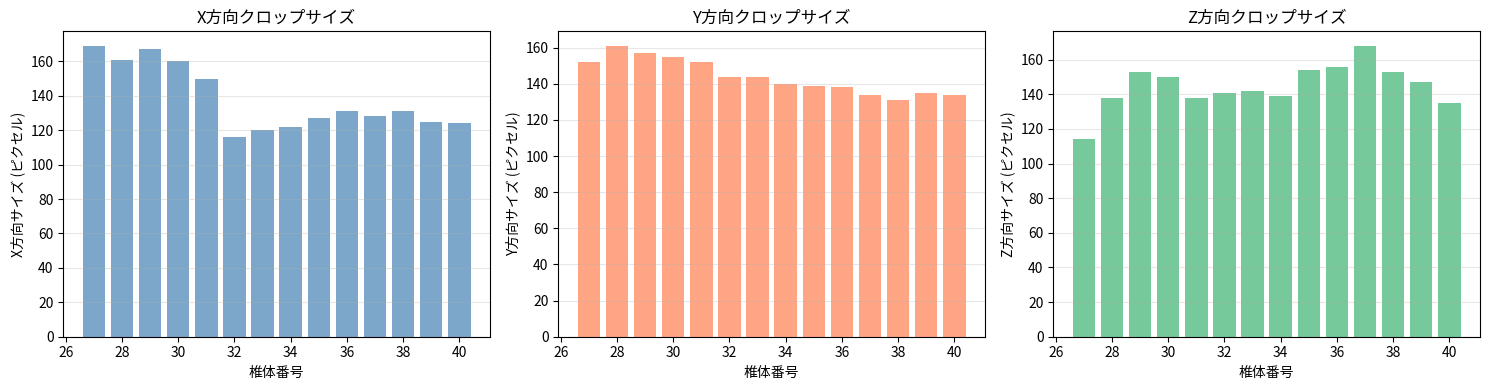


📊 観察:
  - X方向: ほぼ一定 ([169 161 167 160 150 116 120 122 127 131 128 125 124])
  - Y方向: ほぼ一定 ([152 161 157 155 144 140 139 138 134 131 135])
  - Z方向: 椎体ごとに変動 (頭尾方向の椎体の厚み)


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# X, Y, Z方向のサイズ分布
axes[0].bar(cut_info_df['vertebra_num'], cut_info_df['x_size'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('椎体番号')
axes[0].set_ylabel('X方向サイズ (ピクセル)')
axes[0].set_title('X方向クロップサイズ')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(cut_info_df['vertebra_num'], cut_info_df['y_size'], color='coral', alpha=0.7)
axes[1].set_xlabel('椎体番号')
axes[1].set_ylabel('Y方向サイズ (ピクセル)')
axes[1].set_title('Y方向クロップサイズ')
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(cut_info_df['vertebra_num'], cut_info_df['z_size'], color='mediumseagreen', alpha=0.7)
axes[2].set_xlabel('椎体番号')
axes[2].set_ylabel('Z方向サイズ (ピクセル)')
axes[2].set_title('Z方向クロップサイズ')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 観察:")
print(f"  - X方向: ほぼ一定 ({cut_info_df['x_size'].unique()})")
print(f"  - Y方向: ほぼ一定 ({cut_info_df['y_size'].unique()})")
print(f"  - Z方向: 椎体ごとに変動 (頭尾方向の椎体の厚み)")

## 4. クロップされたボリュームの検証

In [4]:
def analyze_cropped_volume(case_id: str = "1003", vertebra_id: str = "27"):
    """
    クロップされたボリュームを分析
    """
    # パス設定
    cropped_ct_path = DATA_ROOT / f"processed_train/inp{case_id}/{vertebra_id}/cut_inp{case_id}.nii.gz"
    cropped_mask_path = DATA_ROOT / f"processed_train/inp{case_id}/{vertebra_id}/cut_ans{case_id}.nii"
    
    if not cropped_ct_path.exists():
        print(f"⚠️ ファイルが見つかりません: {cropped_ct_path}")
        return
    
    # データ読み込み
    ct_img = nib.load(str(cropped_ct_path))
    ct_data = ct_img.get_fdata()
    
    mask_img = nib.load(str(cropped_mask_path))
    mask_data = mask_img.get_fdata()
    
    print(f"\n【ボリューム情報: Case {case_id}, 椎体 {vertebra_id}】")
    print(f"CTボリューム形状: {ct_data.shape}")
    print(f"マスク形状: {mask_data.shape}")
    print(f"HU値範囲: [{ct_data.min():.1f}, {ct_data.max():.1f}]")
    print(f"マスク値: {np.unique(mask_data)}")
    
    # マスク領域の分析
    mask_coords = np.where(mask_data > 0)
    if len(mask_coords[0]) > 0:
        print(f"\nマスク領域:")
        print(f"  X範囲: {mask_coords[0].min()} ~ {mask_coords[0].max()} (サイズ: {mask_coords[0].max() - mask_coords[0].min()})")
        print(f"  Y範囲: {mask_coords[1].min()} ~ {mask_coords[1].max()} (サイズ: {mask_coords[1].max() - mask_coords[1].min()})")
        print(f"  Z範囲: {mask_coords[2].min()} ~ {mask_coords[2].max()} (サイズ: {mask_coords[2].max() - mask_coords[2].min()})")
        
        # 背景比率の計算
        print(f"\n背景比率:")
        print(f"  X方向: {(mask_coords[0].max() - mask_coords[0].min()) / ct_data.shape[0] * 100:.1f}% がマスク領域")
        print(f"  Y方向: {(mask_coords[1].max() - mask_coords[1].min()) / ct_data.shape[1] * 100:.1f}% がマスク領域")
        print(f"  Z方向: {(mask_coords[2].max() - mask_coords[2].min()) / ct_data.shape[2] * 100:.1f}% がマスク領域")
    
    return ct_data, mask_data

# 分析実行
ct_data, mask_data = analyze_cropped_volume("1003", "27")


【ボリューム情報: Case 1003, 椎体 27】
CTボリューム形状: (171, 154, 116)
マスク形状: (171, 154, 116)
HU値範囲: [-1342.0, 2410.0]
マスク値: [0.]


## 5. Axial方向のスライスを可視化して問題を確認

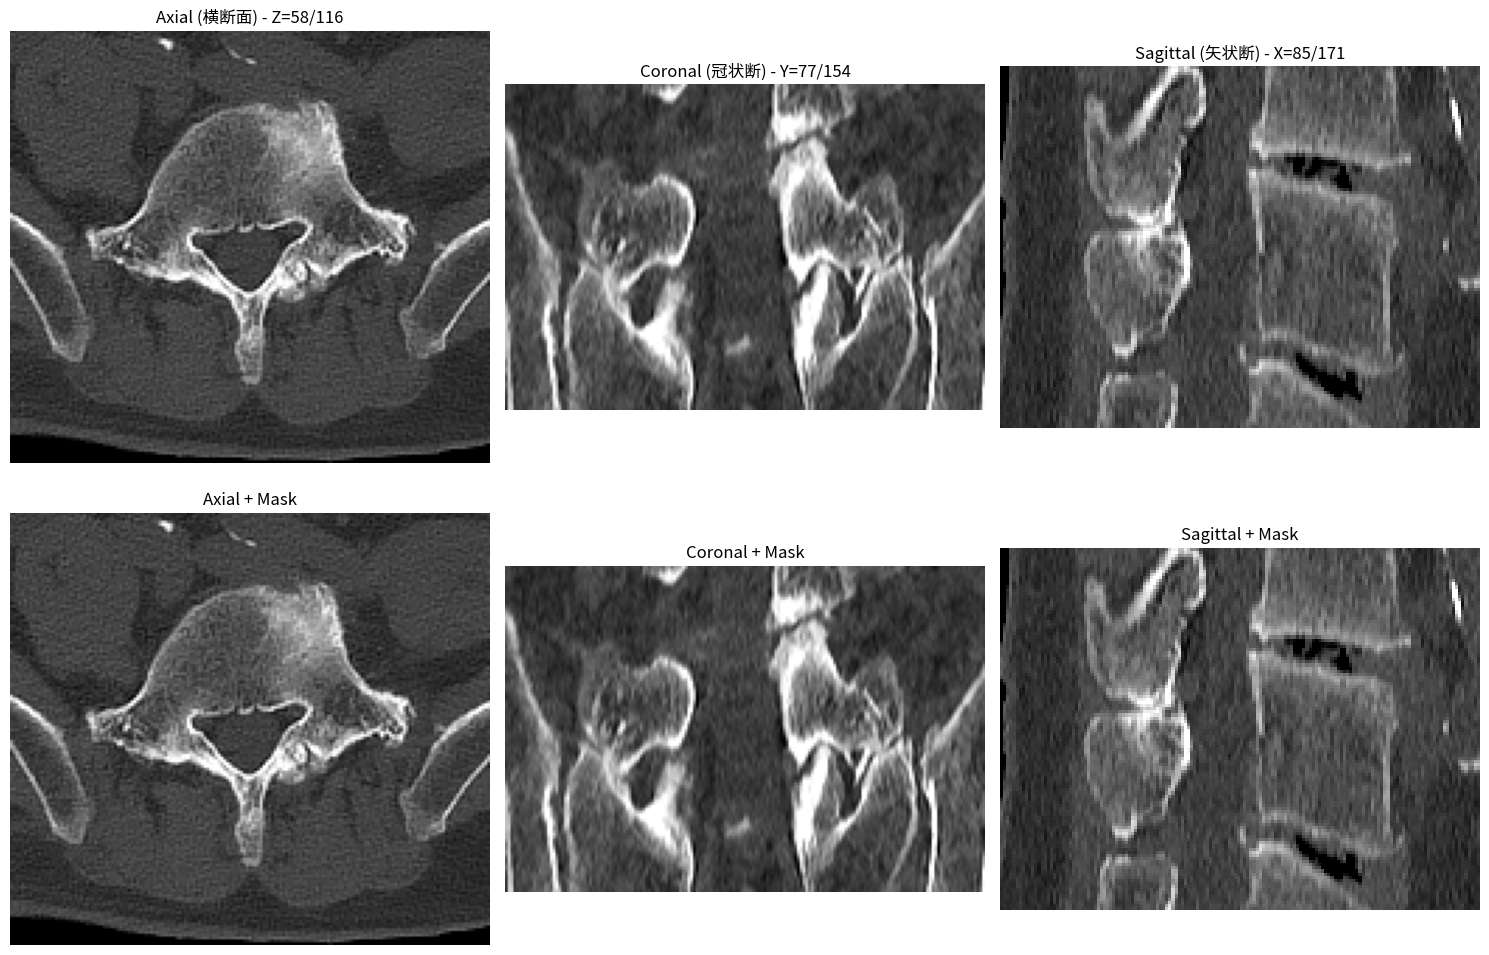


📊 観察ポイント:
  1. Axial(横断面)でX-Y平面に背景が多く見えるか?
  2. Coronal/Sagittalではマスク領域が適切にクロップされているか?
  3. マスク領域がボリュームの中央付近にあるか、端に寄っているか?


In [5]:
def visualize_cropped_volume_slices(ct_data, mask_data):
    """
    クロップされたボリュームの3方向スライスを表示
    """
    H, W, D = ct_data.shape
    
    # 中央スライス
    mid_x = H // 2
    mid_y = W // 2
    mid_z = D // 2
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # HU値ウィンドウ設定(骨条件)
    vmin, vmax = -350, 1150  # center=400, width=1500
    
    # Axial (Z方向のスライス)
    axial_slice = ct_data[:, :, mid_z]
    axial_mask = mask_data[:, :, mid_z]
    axes[0, 0].imshow(axial_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[0, 0].set_title(f'Axial (横断面) - Z={mid_z}/{D}')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(axial_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[1, 0].imshow(axial_mask.T, cmap='Reds', alpha=0.5 * (axial_mask.T > 0), origin='lower')
    axes[1, 0].set_title('Axial + Mask')
    axes[1, 0].axis('off')
    
    # Coronal (Y方向のスライス)
    coronal_slice = ct_data[:, mid_y, :]
    coronal_mask = mask_data[:, mid_y, :]
    axes[0, 1].imshow(coronal_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[0, 1].set_title(f'Coronal (冠状断) - Y={mid_y}/{W}')
    axes[0, 1].axis('off')
    
    axes[1, 1].imshow(coronal_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[1, 1].imshow(coronal_mask.T, cmap='Reds', alpha=0.5 * (coronal_mask.T > 0), origin='lower')
    axes[1, 1].set_title('Coronal + Mask')
    axes[1, 1].axis('off')
    
    # Sagittal (X方向のスライス)
    sagittal_slice = ct_data[mid_x, :, :]
    sagittal_mask = mask_data[mid_x, :, :]
    axes[0, 2].imshow(sagittal_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[0, 2].set_title(f'Sagittal (矢状断) - X={mid_x}/{H}')
    axes[0, 2].axis('off')
    
    axes[1, 2].imshow(sagittal_slice.T, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[1, 2].imshow(sagittal_mask.T, cmap='Reds', alpha=0.5 * (sagittal_mask.T > 0), origin='lower')
    axes[1, 2].set_title('Sagittal + Mask')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 観察ポイント:")
    print("  1. Axial(横断面)でX-Y平面に背景が多く見えるか?")
    print("  2. Coronal/Sagittalではマスク領域が適切にクロップされているか?")
    print("  3. マスク領域がボリュームの中央付近にあるか、端に寄っているか?")

visualize_cropped_volume_slices(ct_data, mask_data)

## 6. クロップ方法の検証

In [6]:
# cut_train.pyのクロップロジックを再現
def _clip(start: int, end: int, maxv: int, margin: int = 1):
    """範囲を margin 分だけ広げてクリップ"""
    return max(start - margin, 0), min(end + margin, maxv)

# サンプルの椎体27番のクロップ情報
vertebra_27_info = cut_info_df[cut_info_df['vertebra_num'] == 27].iloc[0]

print("【椎体27番のクロップパラメータ】")
print(f"元の範囲:")
print(f"  X: {vertebra_27_info['x_start']} ~ {vertebra_27_info['x_end']} (サイズ: {vertebra_27_info['x_size']})")
print(f"  Y: {vertebra_27_info['y_start']} ~ {vertebra_27_info['y_end']} (サイズ: {vertebra_27_info['y_size']})")
print(f"  Z: {vertebra_27_info['z_start']} ~ {vertebra_27_info['z_end']} (サイズ: {vertebra_27_info['z_size']})")

# 元のボリュームサイズを推定(cut_liファイルから)
# 実際のデータを読み込んで確認
original_ct_path = DATA_ROOT / "train/inp1003.nii.gz"
if original_ct_path.exists():
    original_ct = nib.load(str(original_ct_path))
    orig_shape = original_ct.shape
    print(f"\n元のCTボリューム形状: {orig_shape}")
    
    # margin=1を適用した場合の実際のクロップサイズ
    xs, xe = _clip(vertebra_27_info['x_start'], vertebra_27_info['x_end'], orig_shape[0])
    ys, ye = _clip(vertebra_27_info['y_start'], vertebra_27_info['y_end'], orig_shape[1])
    zs, ze = _clip(vertebra_27_info['z_start'], vertebra_27_info['z_end'], orig_shape[2])
    
    print(f"\nmargin=1適用後の範囲:")
    print(f"  X: {xs} ~ {xe} (サイズ: {xe - xs})")
    print(f"  Y: {ys} ~ {ye} (サイズ: {ye - ys})")
    print(f"  Z: {zs} ~ {ze} (サイズ: {ze - zs})")
    
    print(f"\n実際のクロップボリューム: {ct_data.shape}")
    print(f"計算値: ({xe - xs}, {ye - ys}, {ze - zs})")

【椎体27番のクロップパラメータ】
元の範囲:
  X: 164 ~ 333 (サイズ: 169)
  Y: 150 ~ 302 (サイズ: 152)
  Z: 557 ~ 671 (サイズ: 114)

元のCTボリューム形状: (512, 512, 1571)

margin=1適用後の範囲:
  X: 163 ~ 334 (サイズ: 171)
  Y: 149 ~ 303 (サイズ: 154)
  Z: 556 ~ 672 (サイズ: 116)

実際のクロップボリューム: (171, 154, 116)
計算値: (171, 154, 116)


## 7. 問題の根本原因分析

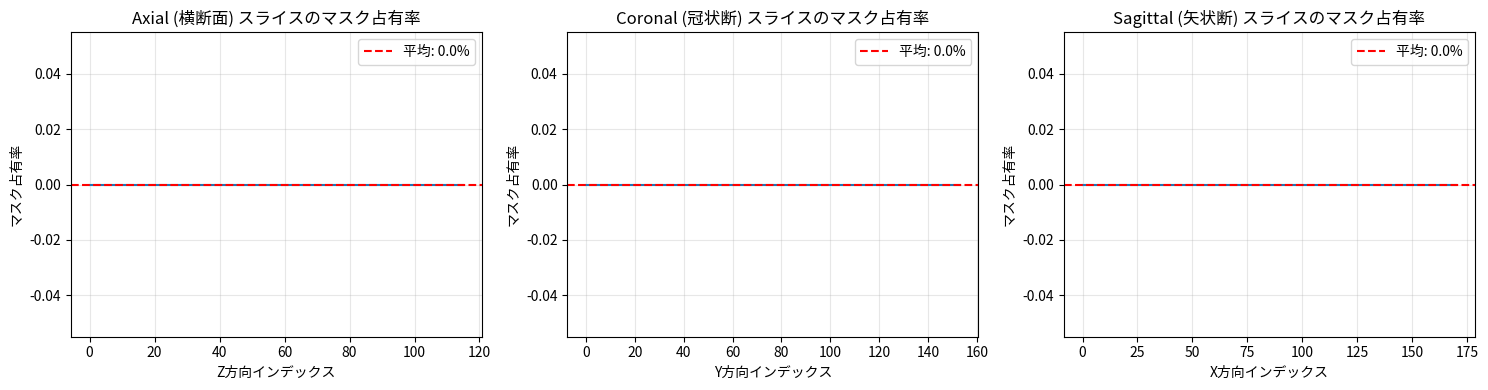


【各方向のマスク占有率統計】
Axial (横断面):   平均 0.00%, 最大 0.00%
Coronal (冠状断): 平均 0.00%, 最大 0.00%
Sagittal (矢状断): 平均 0.00%, 最大 0.00%


In [7]:
def analyze_background_ratio(ct_data, mask_data):
    """
    各軸方向のスライスにおける背景比率を計算
    """
    H, W, D = ct_data.shape
    
    # 各スライスでのマスク占有率を計算
    axial_mask_ratios = []
    coronal_mask_ratios = []
    sagittal_mask_ratios = []
    
    for z in range(D):
        axial_slice_mask = mask_data[:, :, z]
        ratio = np.sum(axial_slice_mask > 0) / axial_slice_mask.size
        axial_mask_ratios.append(ratio)
    
    for y in range(W):
        coronal_slice_mask = mask_data[:, y, :]
        ratio = np.sum(coronal_slice_mask > 0) / coronal_slice_mask.size
        coronal_mask_ratios.append(ratio)
    
    for x in range(H):
        sagittal_slice_mask = mask_data[x, :, :]
        ratio = np.sum(sagittal_slice_mask > 0) / sagittal_slice_mask.size
        sagittal_mask_ratios.append(ratio)
    
    # プロット
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(axial_mask_ratios)
    axes[0].set_xlabel('Z方向インデックス')
    axes[0].set_ylabel('マスク占有率')
    axes[0].set_title('Axial (横断面) スライスのマスク占有率')
    axes[0].grid(alpha=0.3)
    axes[0].axhline(y=np.mean(axial_mask_ratios), color='r', linestyle='--', 
                    label=f'平均: {np.mean(axial_mask_ratios)*100:.1f}%')
    axes[0].legend()
    
    axes[1].plot(coronal_mask_ratios)
    axes[1].set_xlabel('Y方向インデックス')
    axes[1].set_ylabel('マスク占有率')
    axes[1].set_title('Coronal (冠状断) スライスのマスク占有率')
    axes[1].grid(alpha=0.3)
    axes[1].axhline(y=np.mean(coronal_mask_ratios), color='r', linestyle='--',
                    label=f'平均: {np.mean(coronal_mask_ratios)*100:.1f}%')
    axes[1].legend()
    
    axes[2].plot(sagittal_mask_ratios)
    axes[2].set_xlabel('X方向インデックス')
    axes[2].set_ylabel('マスク占有率')
    axes[2].set_title('Sagittal (矢状断) スライスのマスク占有率')
    axes[2].grid(alpha=0.3)
    axes[2].axhline(y=np.mean(sagittal_mask_ratios), color='r', linestyle='--',
                    label=f'平均: {np.mean(sagittal_mask_ratios)*100:.1f}%')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n【各方向のマスク占有率統計】")
    print(f"Axial (横断面):   平均 {np.mean(axial_mask_ratios)*100:.2f}%, 最大 {np.max(axial_mask_ratios)*100:.2f}%")
    print(f"Coronal (冠状断): 平均 {np.mean(coronal_mask_ratios)*100:.2f}%, 最大 {np.max(coronal_mask_ratios)*100:.2f}%")
    print(f"Sagittal (矢状断): 平均 {np.mean(sagittal_mask_ratios)*100:.2f}%, 最大 {np.max(sagittal_mask_ratios)*100:.2f}%")
    
    return axial_mask_ratios, coronal_mask_ratios, sagittal_mask_ratios

axial_ratios, coronal_ratios, sagittal_ratios = analyze_background_ratio(ct_data, mask_data)

## 8. 結論と提案

### 問題の根本原因

**[cut_train.py:87-89]** でのクロップ処理:
```python
def _clip(start: int, end: int, maxv: int, margin: int = 1):
    return max(start - margin, 0), min(end + margin, maxv)
```

1. **X-Y方向(横断面)のクロップが広すぎる**
   - `cut_li*.txt`で指定されるX-Y範囲が、アノテーション領域に対して余裕を持ちすぎている可能性
   - margin=1では不十分で、元の範囲自体が大きい

2. **Z方向(頭尾方向)は適切**
   - 椎体ごとに可変長でクロップされている
   - マスク占有率が高い

### 提案される解決策

#### オプション1: クロップパラメータの再計算
- `cut_li*.txt`生成時にアノテーション領域を厳密に計算し、必要最小限の範囲でクロップ
- 現在のX-Y範囲が `base_size=299` で固定されている可能性あり

#### オプション2: 後処理でタイトクロップ
- 既にクロップされたボリュームに対して、アノテーション領域に基づいて再クロップ
- X-Y方向のみを対象に、マスク領域の境界ボックスを計算して切り出し

#### オプション3: スライス抽出時に動的クロップ
- `slice_train.py`でスライスを保存する際に、各スライスごとにマスク領域に基づいてクロップ
- ただし、スライスごとにサイズが変わるため、バッチ処理が困難になる

### 推奨アプローチ

**オプション2: 後処理でタイトクロップ**が最も実用的:
1. 既存のデータを活用できる
2. 学習時にバッチ処理しやすい均一サイズを維持できる
3. 実装が比較的簡単

次のノートブックで実装例を作成することを推奨します。

## 9. さらなる調査: 複数症例での比較

In [8]:
# 複数症例でマスク占有率を比較
def compare_multiple_cases(case_ids: List[str], vertebra_id: str = "27"):
    """
    複数症例でaxialスライスのマスク占有率を比較
    """
    results = []
    
    for case_id in case_ids:
        ct_path = DATA_ROOT / f"processed_train/inp{case_id}/{vertebra_id}/cut_inp{case_id}.nii.gz"
        mask_path = DATA_ROOT / f"processed_train/inp{case_id}/{vertebra_id}/cut_ans{case_id}.nii"
        
        if not ct_path.exists() or not mask_path.exists():
            continue
        
        ct_data = nib.load(str(ct_path)).get_fdata()
        mask_data = nib.load(str(mask_path)).get_fdata()
        
        # Axialスライスの平均マスク占有率
        mask_ratios = []
        for z in range(ct_data.shape[2]):
            ratio = np.sum(mask_data[:, :, z] > 0) / (ct_data.shape[0] * ct_data.shape[1])
            mask_ratios.append(ratio)
        
        results.append({
            'case_id': case_id,
            'avg_mask_ratio': np.mean(mask_ratios) * 100,
            'max_mask_ratio': np.max(mask_ratios) * 100,
            'shape': ct_data.shape
        })
    
    df = pd.DataFrame(results)
    print(f"\n【複数症例のAxialマスク占有率比較 (椎体{vertebra_id})】")
    print(df.to_string(index=False))
    
    return df

# サンプル症例で比較
sample_cases = ["1003", "1015", "1017", "1025", "1027"]
comparison_df = compare_multiple_cases(sample_cases, "27")


【複数症例のAxialマスク占有率比較 (椎体27)】
case_id  avg_mask_ratio  max_mask_ratio           shape
   1003             0.0             0.0 (171, 154, 116)
   1015             0.0             0.0 (182, 154, 197)
   1017             0.0             0.0 (172, 161, 197)
   1025             0.0             0.0 (167, 159, 113)
   1027             0.0             0.0 (271, 254, 122)
